# Chapter 2 自然言語と単語の分散表現


In [1]:
'''
1. 自然言語処理とは
1. シソーラス
1. カウントベースの手法
1. カウントベースの手法の改善
1. まとめ
'''


'\n1. 自然言語処理とは\n1. シソーラス\n1. カウントベースの手法\n1. カウントベースの手法の改善\n1. まとめ\n'

In [2]:
'''
シソーラスの問題点
- 時代の変化に対応するのが困難
- 人の作業コストが高い
- 単語の細かなニュアンスを表現できない
'''

'\nシソーラスの問題点\n- 時代の変化に対応するのが困難\n- 人の作業コストが高い\n- 単語の細かなニュアンスを表現できない\n'

# コーパスの前処理


In [3]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


In [4]:
text = "you say goodbye and i say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)


[0 1 2 3 4 1 5 6]


# 共起行列の作成


In [5]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


In [6]:
create_co_matrix(corpus, 7)


array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

# cosine類似度


In [7]:
def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)



In [8]:
C = create_co_matrix(corpus, 7)
c0 = C[word_to_id["you"]]
c1 = C[word_to_id["i"]]
print(cos_similarity(c0, c1))


0.7071067691154799


In [9]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [10]:
most_similar('you', word_to_id, id_to_word, C, top=5)



[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


# 相互情報量基準


In [11]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか    
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M


In [12]:
print("covariance matrix")
C

covariance matrix


array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [13]:
print("ppmi")
ppmi(C)


ppmi


array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

# SVDによる次元削減


In [14]:
W = ppmi(C)
U,S,V = np.linalg.svd(W)


In [15]:
print(U.shape)
print(U)


(7, 7)
[[ 3.40948761e-01  0.00000000e+00 -1.20516241e-01 -3.88578059e-16
  -9.32324946e-01 -1.11022302e-16 -2.42574685e-17]
 [ 0.00000000e+00 -5.97636402e-01  0.00000000e+00  1.80237904e-01
   0.00000000e+00 -7.81245828e-01  0.00000000e+00]
 [ 4.36312199e-01 -5.55111512e-17 -5.08782864e-01 -2.22044605e-16
   2.25325629e-01 -1.38777878e-17 -7.07106769e-01]
 [ 1.11022302e-16 -4.97828126e-01  2.77555756e-17  6.80396318e-01
  -1.11022302e-16  5.37799239e-01  7.46693292e-17]
 [ 4.36312199e-01 -3.12375064e-17 -5.08782864e-01 -1.59998290e-16
   2.25325629e-01 -1.30164976e-17  7.07106769e-01]
 [ 7.09237099e-01 -3.12375064e-17  6.83926761e-01 -1.59998290e-16
   1.70958877e-01 -1.30164976e-17  2.31390806e-17]
 [-1.66533454e-16 -6.28488600e-01 -4.16333634e-17 -7.10334539e-01
   2.22044605e-16  3.16902101e-01 -9.61431563e-17]]


In [16]:
print(S.shape)
print(S)


(7,)
[3.1680453e+00 3.1680453e+00 2.7029872e+00 2.7029872e+00 1.5144811e+00
 1.5144811e+00 4.1317175e-17]


In [17]:
print(V.shape)
print(V)


(7, 7)
[[-0.0000000e+00  5.9763640e-01  1.6653345e-16  4.9782813e-01
   2.7755576e-16 -2.2204460e-16  6.2848860e-01]
 [-3.4094876e-01  0.0000000e+00 -4.3631220e-01  0.0000000e+00
  -4.3631220e-01 -7.0923710e-01 -0.0000000e+00]
 [ 0.0000000e+00 -1.8023790e-01  1.3877788e-17 -6.8039632e-01
  -1.1102230e-16  8.3266727e-17  7.1033454e-01]
 [ 1.2051624e-01 -5.5511151e-16  5.0878286e-01  0.0000000e+00
   5.0878286e-01 -6.8392676e-01 -0.0000000e+00]
 [ 0.0000000e+00 -7.8124583e-01 -3.3306691e-16  5.3779924e-01
  -1.6653345e-16  2.7755576e-16  3.1690210e-01]
 [-9.3232495e-01 -5.5511151e-17  2.2532563e-01  0.0000000e+00
   2.2532563e-01  1.7095888e-01 -0.0000000e+00]
 [ 0.0000000e+00 -3.2049378e-17 -7.0710677e-01  2.7755576e-17
   7.0710677e-01 -3.7007435e-17 -2.7755576e-17]]


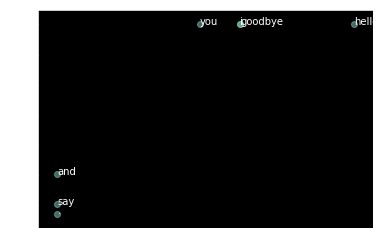

In [18]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


# PTBデータセット


In [19]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])



corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


# PTBデータセットでの評価


In [20]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)



counting  co-occurrence ...


calculating PPMI ...


1.0% done


2.0% done


3.0% done


4.0% done


5.0% done


6.0% done


7.0% done


8.0% done


9.0% done


10.0% done


11.0% done


12.0% done


13.0% done


14.0% done


15.0% done


16.0% done


17.0% done


18.0% done


19.0% done


20.0% done


21.0% done


22.0% done


23.0% done


24.0% done


25.0% done


26.0% done


27.0% done


28.0% done


29.0% done


30.0% done


31.0% done


32.0% done


33.0% done


34.0% done


35.0% done


36.0% done


37.0% done


38.0% done


39.0% done


40.0% done


41.0% done


42.0% done


43.0% done


44.0% done


45.0% done


46.0% done


47.0% done


48.0% done


49.0% done


50.0% done


51.0% done


52.0% done


53.0% done


54.0% done


55.0% done


56.0% done


57.0% done


58.0% done


59.0% done


60.0% done


61.0% done


62.0% done


63.0% done


64.0% done


65.0% done


66.0% done


67.0% done


68.0% done


69.0% done


70.0% done


71.0% done


72.0% done


73.0% done


74.0% done


75.0% done


76.0% done


77.0% done


78.0% done


79.0% done


80.0% done


81.0% done


82.0% done


83.0% done


84.0% done


85.0% done


86.0% done


87.0% done


88.0% done


89.0% done


90.0% done


91.0% done


92.0% done


93.0% done


94.0% done


95.0% done


96.0% done


97.0% done


98.0% done


99.0% done


100.0% done
calculating SVD ...



[query] you


 i: 0.7248993515968323
 do: 0.6391043663024902
 we: 0.582492470741272
 someone: 0.5320316553115845
 guess: 0.5246246457099915

[query] year


 month: 0.6375702619552612
 earlier: 0.6364588141441345
 last: 0.619536817073822
 quarter: 0.6189979910850525
 february: 0.5782645344734192

[query] car


 luxury: 0.6362413167953491
 auto: 0.6282631754875183
 cars: 0.5141884684562683
 corsica: 0.4598488211631775
 vehicle: 0.43534183502197266

[query] toyota


 motor: 0.7456129193305969
 motors: 0.6991701722145081
 nissan: 0.6470730304718018
 lexus: 0.6125632524490356
 honda: 0.5929207801818848
